## Loan Approved or Denied - Decision Tree

**===================================================**

### Data Preparation

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 1500)

import warnings
warnings.filterwarnings('ignore')

# Extend cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
def describe_more(df,normalize_ind=False, weight_column=None, skip_columns=[], dropna=True):
    var = [] ; l = [] ; t = []; unq =[]; min_l = []; max_l = [];
    assert isinstance(skip_columns, list), "Argument skip_columns should be list"
    if weight_column is not None:
        if weight_column not in list(df.columns):
            raise AssertionError('weight_column is not a valid column name in the input DataFrame')
      
    for x in df:
        if x in skip_columns:
            pass
        else:
            var.append( x )
            uniq_counts = len(pd.value_counts(df[x],dropna=dropna))
            uniq_counts = len(pd.value_counts(df[x], dropna=dropna)[pd.value_counts(df[x],dropna=dropna)>0])
            l.append(uniq_counts)
            t.append( df[ x ].dtypes )
            min_l.append(df[x].apply(str).str.len().min())
            max_l.append(df[x].apply(str).str.len().max())
            if weight_column is not None and x not in skip_columns:
                df2 = df.groupby(x).agg({weight_column: 'sum'}).sort_values(weight_column, ascending=False)
                df2['authtrans_vts_cnt']=((df2[weight_column])/df2[weight_column].sum()).round(2)
                unq.append(df2.head(n=100).to_dict()[weight_column])
            else:
                df_cat_d = df[x].value_counts(normalize=normalize_ind,dropna=dropna).round(decimals=2)
                df_cat_d = df_cat_d[df_cat_d>0]
                #unq.append(df[x].value_counts().iloc[0:100].to_dict())
                unq.append(df_cat_d.iloc[0:100].to_dict())
            
    levels = pd.DataFrame( { 'A_Variable' : var , 'Levels' : l , 'Datatype' : t ,
                             'Min Length' : min_l,
                             'Max Length': max_l,
                             'Level_Values' : unq} )
    #levels.sort_values( by = 'Levels' , inplace = True )
    return levels

In [3]:
X_train = pd.read_csv('SBA_loans_train.csv')
X_test  = pd.read_csv('SBA_loans_test.csv')
orig_columns = list(X_train.columns)

In [4]:
print(orig_columns)

['City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv', 'Defaulted']


In [5]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (337186, 20)
Test shape: (112396, 20)


#### Review Dataset

In [6]:
# pd.set_option('display.width', 1000)
# pd.set_option('max_colwidth',200)
desc_df = describe_more(X_train)
desc_df

,A_Variable,Levels,Datatype,Min Length,Max Length,Level_Values
0,City,22069,object,1,30,"{'LOS ANGELES': 4278, 'HOUSTON': 3801, 'NEW YO..."
1,State,51,object,2,3,"{'CA': 49031, 'TX': 26500, 'NY': 21508, 'FL': ..."
2,Zip,26044,int64,1,5,"{90015: 344, 10001: 328, 93401: 308, 33166: 26..."
3,Bank,4833,object,3,30,"{'BANK OF AMERICA NATL ASSOC': 32382, 'WELLS F..."
4,BankState,55,object,2,3,"{'CA': 44497, 'NC': 29717, 'IL': 24674, 'OH': ..."
5,NAICS,1279,int64,1,6,"{0: 75763, 722110: 10456, 722211: 7319, 811111..."
6,Term,372,int64,1,3,"{84: 86087, 60: 33770, 240: 32245, 120: 29056,..."
7,NoEmp,433,int64,1,4,"{1: 57553, 2: 51865, 3: 34228, 4: 27633, 5: 22..."
8,NewExist,3,float64,3,3,"{1.0: 241894, 2.0: 94857, 0.0: 389}"
9,CreateJob,180,int64,1,4,"{0: 236015, 1: 23537, 2: 21779, 3: 10849, 4: 7..."


In [7]:
X_train.describe()

,Zip,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,Defaulted
count,337186.000000,337186.000000,337186.000000,337186.000000,337140.000000,337186.000000,337186.000000,337186.000000,337186.000000,3.371860e+05,337186.000000,3.371860e+05,3.371860e+05,337186.000000
mean,53839.723945,398565.095974,110.888984,11.310229,1.280204,8.590790,10.977176,2754.662685,0.758050,2.021301e+05,5.643016,1.935411e+05,1.501295e+05,0.175191
std,31173.277974,263305.463724,78.951681,68.753263,0.451661,239.591219,240.184246,12749.672453,0.646786,2.892966e+05,2232.801967,2.847135e+05,2.293072e+05,0.380131
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000e+02,1.000000e+02,0.000000
25%,27604.250000,235210.000000,60.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,4.201250e+04,0.000000,3.500000e+04,2.125000e+04,0.000000
50%,55414.000000,445310.000000,84.000000,4.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000e+05,0.000000,9.000000e+04,6.210000e+04,0.000000
75%,83706.000000,561730.000000,120.000000,10.000000,2.000000,1.000000,4.000000,1.000000,1.000000,2.400000e+05,0.000000,2.270000e+05,1.750000e+05,0.000000
max,99999.000000,928120.000000,505.000000,9999.000000,2.000000,8800.000000,9500.000000,99999.000000,2.000000,1.100000e+07,996262.000000,5.000000e+06,4.869000e+06,1.000000


In [8]:
X_train.head()

,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,Defaulted
0,Huntsville,AL,35811,"BUSINESS LOAN CENTER, LLC",FL,621310,73,1,2.0,2,1,0,1,N,N,25000.0,0.0,25000.0,21250.0,1
1,SCOTTSDALE,AZ,85254,WELLS FARGO BANK NATL ASSOC,CA,0,84,3,2.0,0,0,0,0,N,N,52000.0,0.0,52000.0,46800.0,1
2,BANGOR,ME,4401,BANGOR SAVINGS BANK,ME,323110,84,9,1.0,0,0,1,1,0,Y,150000.0,0.0,150000.0,127500.0,0
3,AVONDALE,AZ,85323,NATIONAL BANK OF ARIZONA,AZ,722110,27,20,1.0,0,20,10625,2,Y,N,186959.0,0.0,100000.0,50000.0,1
4,HAMMOND,LA,70403,"BIZCAPITAL BIDCO II, LLC",LA,0,60,1,1.0,0,0,1,1,0,Y,50000.0,0.0,50000.0,40000.0,0


Explore levels and counts in the RevLineCr column. Some column values needs to be "cleaned"

In [9]:
desc_df.iloc[13]["Level_Values"]

{'N': 157494,
 '0': 96923,
 'Y': 75248,
 'T': 5797,
 'R': 7,
 '1': 6,
 '`': 2,
 '2': 1,
 ',': 1,
 '7': 1,
 'A': 1,
 '-': 1,
 'Q': 1}

Replace missing values for all columns for both X_train and X_test

Replace Na's with zero for numerical variables and with "Missing" for categorical

In [10]:
values_to_fill = {}
for col in X_train.drop(columns=['Defaulted']).columns:
    if X_train[col].dtype == 'object':
        values_to_fill[col] = "Missing"
    else:
        values_to_fill[col] = 0

X_train.fillna(value=values_to_fill,inplace=True)
X_test.fillna(value=values_to_fill, inplace=True)

#### Encode Categorical Variables

I'm going to use Decision Tree approach, so I will not use One-Hot-Encoding. Instead, I will use  Label Encoding, Target Encoding and Weight of Evidence Encoding

In [11]:
len_data = len(X_train)
for col in X_train.drop(columns=['Defaulted']).columns:
  if X_train[col].dtype == 'object':
    print("Column ",col," has ",X_train[col].nunique()," values")

Column  City  has  22070  values
Column  State  has  52  values
Column  Bank  has  4834  values
Column  BankState  has  56  values
Column  RevLineCr  has  14  values
Column  LowDoc  has  8  values


In [12]:
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from copy import deepcopy

# Save original columns need to be droped or not used
orig_categorical_columns = []
cat_encoders = {}
le_columns = []

# Label
for col in X_train.drop(columns=['Defaulted']).columns:
  if X_train[col].dtype == 'object':
    print("Encode column:...", col)
    enc = LabelEncoder()
    enc.fit(list(X_train[col])+list(X_test[col]))
    X_train[col+"_le"] = enc.transform(X_train[[col]])
    X_test[col+"_le"] = enc.transform(X_test[[col]])
    cat_encoders[(col,"le")] = [deepcopy(enc),"le"]
    orig_categorical_columns.append(col)
    le_columns.append(col+"_le")

Encode column:... City
Encode column:... State
Encode column:... Bank
Encode column:... BankState
Encode column:... RevLineCr
Encode column:... LowDoc


In [13]:
orig_categorical_columns

['City', 'State', 'Bank', 'BankState', 'RevLineCr', 'LowDoc']

In [14]:
le_columns

['City_le', 'State_le', 'Bank_le', 'BankState_le', 'RevLineCr_le', 'LowDoc_le']

In [15]:
label_col = 'Defaulted'

# Target
target_encoder = ce.TargetEncoder (min_samples_leaf=20, smoothing=10)
target_encoder.fit(X_train[orig_categorical_columns],X_train[label_col])
X_train_target_enc = target_encoder.transform(X_train[orig_categorical_columns])
X_test_target_enc = target_encoder.transform(X_test[orig_categorical_columns])

# Weight of Evidence
woe_encoder = ce.WOEEncoder(cols=orig_categorical_columns)
woe_encoder.fit(X_train[orig_categorical_columns],X_train[label_col])
X_train_woe_enc = woe_encoder.transform(X_train[orig_categorical_columns])
X_test_woe_enc = woe_encoder.transform(X_test[orig_categorical_columns])


te_columns = []
woe_columns = []
for col in orig_categorical_columns:
    X_train[col+"_te"] = X_train_target_enc[col]
    X_test[col+"_te"] = X_test_target_enc[col]
    te_columns.append(col+"_te")
    
    X_train[col+"_woe"] = X_train_woe_enc[col]
    X_test[col+"_woe"] = X_test_woe_enc[col]
    woe_columns.append(col+"_woe")

cat_encoders[("orig_categorical_columns","te")] = [deepcopy(target_encoder),"te"]
cat_encoders[("orig_categorical_columns","woe")] = [deepcopy(woe_encoder),"woe"]

In [16]:
cat_encoders['orig_categorical_columns','te']

[TargetEncoder(cols=['City', 'State', 'Bank', 'BankState', 'RevLineCr',
                     'LowDoc']),
 'te']

### Train Decision Tree Model

Metrics are F1 and Confusion Matrix

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

non_categorical_columns = [col for col in orig_columns if col not in orig_categorical_columns]
non_categorical_columns.remove(label_col)

max_depth = 10

# Train Decision Tree with Lable Encoding
dtc = DecisionTreeClassifier(random_state=0, 
                             criterion="entropy",
                             max_depth=max_depth)

dtc.fit(X_train[non_categorical_columns+le_columns], X_train[label_col])

y_tst_pred = dtc.predict(X_test[non_categorical_columns+le_columns])
y_tr_pred = dtc.predict(X_train[non_categorical_columns+le_columns])
print("Trained Decision Tree with Lable Encoding",)
f1 = f1_score(X_test[label_col], y_tst_pred, average='weighted')
print("Test F1 score:...",f1)
print("====Confusion Matrix===")
print(confusion_matrix(X_test[label_col], y_tst_pred))
print("\n")

Trained Decision Tree with Lable Encoding
Test F1 score:... 0.927703985243013
====Confusion Matrix===
[[88836  3853]
 [ 4241 15466]]




In [18]:
# Train Decision Tree with Target Encoding
dtc = DecisionTreeClassifier(random_state=0, 
                             criterion="entropy",
                             max_depth=max_depth)

dtc.fit(X_train[non_categorical_columns+te_columns], X_train[label_col])

y_tst_pred = dtc.predict(X_test[non_categorical_columns+te_columns])
y_tr_pred = dtc.predict(X_train[non_categorical_columns+te_columns])
print("Trained Decision Tree with TE Encoding",)
f1 = f1_score(X_test[label_col], y_tst_pred, average='weighted')
print("Test F1 score:...",f1)
print("====Confusion Matrix===")
print(confusion_matrix(X_test[label_col], y_tst_pred))
print("\n")

Trained Decision Tree with TE Encoding
Test F1 score:... 0.9280157378017886
====Confusion Matrix===
[[89095  3594]
 [ 4428 15279]]




In [19]:
# Train Decision Tree with Weight of Evidence Encoding
dtc = DecisionTreeClassifier(random_state=0, 
                             criterion="entropy",
                             max_depth=max_depth)

dtc.fit(X_train[non_categorical_columns+woe_columns], X_train[label_col])

y_tst_pred = dtc.predict(X_test[non_categorical_columns+woe_columns])
y_tr_pred = dtc.predict(X_train[non_categorical_columns+woe_columns])
print("Trained Decision Tree with WOE Encoding",)
f1 = f1_score(X_test[label_col], y_tst_pred, average='weighted')
print("Test F1 score:...",f1)
print("====Confusion Matrix===")
print(confusion_matrix(X_test[label_col], y_tst_pred))
print("\n")

Trained Decision Tree with WOE Encoding
Test F1 score:... 0.9247565682735117
====Confusion Matrix===
[[89584  3105]
 [ 5169 14538]]




### Hyper-Parameters Tuning

In [20]:
X_train.head()

,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,Defaulted,City_le,State_le,Bank_le,BankState_le,RevLineCr_le,LowDoc_le,City_te,City_woe,State_te,State_woe,Bank_te,Bank_woe,BankState_te,BankState_woe,RevLineCr_te,RevLineCr_woe,LowDoc_te,LowDoc_woe
0,Huntsville,AL,35811,"BUSINESS LOAN CENTER, LLC",FL,621310,73,1,2.0,2,1,0,1,N,N,25000.0,0.0,25000.0,21250.0,1,10027,1,803,11,9,4,0.283212,1.107415,0.167744,-0.050917,0.308181,0.741374,0.158105,-0.122172,0.146342,-0.214300,0.186457,0.076065
1,SCOTTSDALE,AZ,85254,WELLS FARGO BANK NATL ASSOC,CA,0,84,3,2.0,0,0,0,0,N,N,52000.0,0.0,52000.0,46800.0,1,19482,3,4997,5,9,4,0.191919,0.118312,0.200634,0.167471,0.138341,-0.279641,0.221678,0.293405,0.146342,-0.214300,0.186457,0.076065
2,BANGOR,ME,4401,BANGOR SAVINGS BANK,ME,323110,84,9,1.0,0,0,1,1,0,Y,150000.0,0.0,150000.0,127500.0,0,1058,21,381,23,2,7,0.125985,-0.336038,0.096586,-0.682359,0.062502,-1.049319,0.076696,-0.930088,0.149252,-0.191171,0.090740,-0.755151
3,AVONDALE,AZ,85323,NATIONAL BANK OF ARIZONA,AZ,722110,27,20,1.0,0,20,10625,2,Y,N,186959.0,0.0,100000.0,50000.0,1,740,3,3292,4,13,4,0.351182,1.063740,0.200634,0.167471,0.059406,-1.162305,0.068197,-1.056343,0.253136,0.467327,0.186457,0.076065
4,HAMMOND,LA,70403,"BIZCAPITAL BIDCO II, LLC",LA,0,60,1,1.0,0,0,1,1,0,Y,50000.0,0.0,50000.0,40000.0,0,8869,18,708,20,2,7,0.275805,0.622485,0.179574,0.031247,0.362410,1.072323,0.101741,-0.624053,0.149252,-0.191171,0.090740,-0.755151


Split Train dataset using 80/20 split to Train/Validation

Use new Train dataset to fit the model

Use Validation dataset to evaluate and identify the best model

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Split X_train to Train and Validation
X = X_train.copy()
Y = X_train[label_col]
X_tr, X_val, Y_tr, Y_val = train_test_split(X, Y, test_size=0.2, random_state=0)

X_tr = X_tr[non_categorical_columns+te_columns]
X_val = X_val[non_categorical_columns+te_columns]
X_tst = X_test[non_categorical_columns+te_columns]
Y_tst = X_test[label_col]

Metrics are
- Set of Hyper Parameters used to train the model
- F1 and confusion matrix on Validation dataset 
- F1 and confusion matrix on Test dataset

In [22]:
best_f1 = 0
best_params = {}
best_model = None

for max_depth in [5,10,12,15,20]:
    for min_samples_split in [25, 50, 75]:
        for min_impurity_decrease in [0.0, 0.02, 0.05]:
            dtc = DecisionTreeClassifier(random_state=0, 
                                         criterion="entropy",
                                         max_depth=max_depth,
                                         min_samples_split=min_samples_split,
                                         min_impurity_decrease=min_impurity_decrease)

            dtc.fit(X_tr, Y_tr)
            y_val_pred = dtc.predict(X_val)
            # print("Trained Decision Tree with (max_dept, min_samples_split, min_impurity_decrease):(", \
            #                     max_depth, min_samples_split,min_impurity_decrease,")")
            f1 = f1_score(Y_val, y_val_pred, average='weighted')
            if f1>best_f1:
                best_f1 = f1
                best_params["max_depth"] = max_depth
                best_params["min_samples_split"] = min_samples_split
                best_params["min_impurity_decrease"] = min_impurity_decrease
            # print("F1 for Validation Dataset:", f1)

In [23]:
# Best parameters
print("Best params:", best_params)

Best params: {'max_depth': 15, 'min_samples_split': 50, 'min_impurity_decrease': 0.0}


### Train Decision Tree Model Best Parameters

In [24]:
best_model = DecisionTreeClassifier(random_state=0, 
                                     criterion="entropy",
                                     max_depth=best_params["max_depth"],
                                     min_samples_split=best_params["min_samples_split"],
                                     min_impurity_decrease=best_params["min_impurity_decrease"])
best_model.fit(X_tr, Y_tr)

y_val_pred = best_model.predict(X_val)
f1_val = f1_score(Y_val, y_val_pred, average='weighted')

In [25]:
y_tst_pred = best_model.predict(X_tst)
y_val_pred = best_model.predict(X_val)

f1_val = f1_score(Y_val, y_val_pred, average='weighted')
print("F1 for Validation:", f1_val)
f1_tst = f1_score(Y_tst, y_tst_pred, average='weighted')
print("F1 for Test:", f1_tst)
print("Test set confusion matrix:")
print(confusion_matrix(Y_tst, y_tst_pred))

F1 for Validation: 0.9366446218653249
F1 for Test: 0.9337267853087968
Test set confusion matrix:
[[89583  3106]
 [ 4255 15452]]


#### Re-train Decision Tree Model

Train model with best parameters on full train dataset

Evaluate model performance on test dataset.

In [26]:
X_tr = X[non_categorical_columns+te_columns]
Y_tr = Y
best_model_full = DecisionTreeClassifier(random_state=0, 
                                     criterion="entropy",
                                     max_depth=best_params["max_depth"],
                                     min_samples_split=best_params["min_samples_split"],
                                     min_impurity_decrease=best_params["min_impurity_decrease"])
best_model_full.fit(X_tr, Y_tr)

y_tst_pred = best_model_full.predict(X_tst)

f1_tst = f1_score(Y_tst, y_tst_pred, average='weighted')
print("F1 for Test:", f1_tst)
print("Test set confusion matrix:")
print(confusion_matrix(Y_tst, y_tst_pred))

F1 for Test: 0.9346018040410864
Test set confusion matrix:
[[89665  3024]
 [ 4235 15472]]


### Feature Importance

Produce visualization of the best model feature importance's

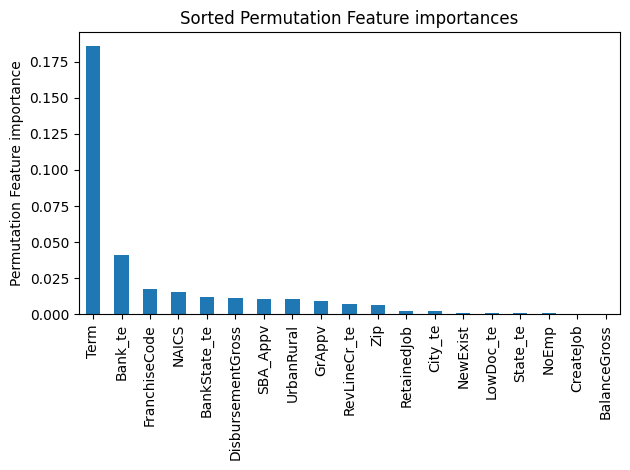

In [27]:
# Calculate feature importance using permutation method
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

%matplotlib inline
result = permutation_importance(
    best_model_full, X_tst, Y_tst, n_repeats=100, random_state=42, n_jobs=4
)

feature_names = X_tst.columns
tree_importances = pd.Series(result.importances_mean, index=feature_names)
tree_importances = tree_importances.sort_values(ascending=False)

fig, ax = plt.subplots()
tree_importances.plot.bar(ax=ax)
ax.set_title("Sorted Permutation Feature importances")
ax.set_ylabel("Permutation Feature importance")
fig.tight_layout()